In [ ]:
! pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


# Load Data

In [1]:
!gdown "1EHysCIx0PHVDj4PvBIdm-d0dkpp4cdY8" #data

Downloading...
From: https://drive.google.com/uc?id=1EHysCIx0PHVDj4PvBIdm-d0dkpp4cdY8
To: /content/data_4.zip
100% 11.5M/11.5M [00:00<00:00, 30.4MB/s]


In [2]:
! unzip "/content/data_4.zip"

Archive:  /content/data_4.zip
  inflating: x_train.npz             
  inflating: y_train.npz             
 extracting: y_test.npz              
  inflating: x_test.npz              


In [5]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [33]:
x_train = np.load("x_train.npz")["arr_0"]
x_test = np.load("x_test.npz")["arr_0"]
y_train = np.load("y_train.npz")["arr_0"]
y_test = np.load("y_test.npz")["arr_0"]

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [36]:
x_test = x_test.reshape(x_test.shape[0], -1)
x_train = x_train.reshape(x_train.shape[0], -1)
x_valid = x_valid.reshape(x_valid.shape[0], -1)
y_train = np.eye(10)[np.squeeze(y_train)]
y_train = y_train.T
y_test = np.eye(10)[np.squeeze(y_test)]
y_test = y_test.T
y_valid = np.eye(10)[np.squeeze(y_valid)]
y_valid = y_valid.T


In [38]:
x_train.shape

(42000, 784)

# Normalization

In [10]:
def normalize(x_train, x_valid, x_test):

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_valid = x_valid.astype('float32') / 255.0

    return x_train, x_valid, x_test

# Standardization

In [11]:
def standardize(x_train, x_valid, x_test):

    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)
    std[std == 0] = 1e-8

    x_train = (x_train - mean) / std
    x_valid = (x_valid - mean) / std
    x_test_= (x_test - mean) / std


    return x_train, x_valid, x_test

In [12]:
print("Original x_train shape:", x_train.shape)
print("Standardized x_train shape:", x_train_stand.shape)
print("Original x_valid shape:", x_valid.shape)
print("Standardized x_valid shape:", x_valid_stand.shape)
print("Original x_test shape:", x_test.shape)
print("Standardized x_test shape:", x_test_stand.shape)

Original x_train shape: (42000, 784)


NameError: name 'x_train_stand' is not defined

# Activation Function

In [13]:
def softmax(Z):
    """
    Computes the softmax activation for a given input Z.

    Arguments:
    Z -- numpy array of shape (n_classes, m), where n_classes is the number of classes and m is the number of examples.

    Returns:
    A -- output of the softmax activation, same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    # Calculate softmax
    exp_Z = np.exp(Z - np.max(Z))  # Subtracting the maximum to avoid overflow
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    cache = Z  # Save Z for backpropagation

    return A

def softmax_backward(dA, cache):
    """
    Computes the gradient of the softmax activation with respect to the input Z.

    Arguments:
    dA -- post-activation gradient, of shape (n_classes, m)
    cache -- Z, where Z is the input of the softmax layer (same shape as dA)

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    exp_Z = np.exp(Z - np.max(Z))  # Subtracting the maximum to avoid overflow
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

    # Compute the gradient of the softmax
    dZ = A * (dA - np.sum(A * dA, axis=0, keepdims=True))

    return dZ


In [14]:
def relu(Z):
    """
    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A

def relu_backward(dA, cache):
    """
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

In [15]:
def sigmoid(Z):
    """
    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A

def sigmoid_backward(dA, cache):
    """
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ

# Parameter

In [16]:
def initialize_parameters_he(layers_dims):
    """
    Initialize parameters using He initialization.

    Arguments:
    layers_dims -- python array (list) containing the size of each layer.

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1  # number of layers

    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2. / layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        # for key, value in parameters.items():
        #   if key.startswith('W'):
        #       print(f'Shape of {key}: {value.shape}')
        #   elif key.startswith('b'):
        #       print(f'Shape of {key}: {value.shape}')


    return parameters


In [17]:
def initialize_parameters_xavier(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """

    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(1.0 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters


In [18]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL"
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.

    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl

    Returns:
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}

    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))


    return v, s

In [19]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam

    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates
    beta2 -- Exponential decay hyperparameter for the second moment estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}

    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads['db' + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads['db' + str(l+1)])

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return parameters, v, s

# Mini Batch

In [29]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y =  Y[:, permutation].reshape((10,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

# Forward & Backward

In [21]:
def forward_propagation(X, Y, parameters, activation="relu",activationlast = "sigmoid"):
    """
    Implements the forward propagation for the neural network.

    Args:
      X (np.ndarray): The input data, of shape (input_size, num_examples).
      parameters (dict): Dictionary containing the parameters (W and b) of the model.
      activation (str): Activation function to be used ("relu", "sigmoid", "tanh", "leaky_relu", "identity").

    Returns:
      AL (np.ndarray): The output of the last activation, also known as the predicted label.
      cache (tuple): A tuple containing caches for each layer: (z1, a1, W1, b1, z2, a2, W2, b2, ..., zL, aL_prev, WL, bL).
    """
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers
    m = X.shape[1]

    # Implement [LINEAR -> ACTIVATION]*(L-1)
    for l in range(1, L):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        Z = np.dot(W, A_prev) + b
        if activation == "relu":
            A = relu(Z)
        elif activation == "sigmoid":
            A = sigmoid(Z)
        elif activation == "softmax":
            A = softmax(Z)

        linear_cache = (Z, A, W, b)

        caches.append(linear_cache)

    # Implement LINEAR -> ACTIVATION for the last layer (output layer)
    AL_prev = A
    WL = parameters["W" + str(L)]
    bL = parameters["b" + str(L)]
    ZL = np.dot(WL, AL_prev) + bL
    if activationlast == "sigmoid":
        AL = sigmoid(ZL)
    elif activationlast == "relu":
        AL = relu(ZL)
    elif activationlast == "softmax":
        AL = softmax(ZL)
    linear_cache_L = (ZL, AL, WL, bL)
    caches.append(linear_cache_L)
    # print(ZL[0][0])
    # linear_cache_L = caches[len(caches)-1]
    # print(linear_cache_L[0])
    # print(len(caches))
    # cache_type = type(caches)
    # print("Type of caches:", cache_type)

    # logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    # cost = 1./m * np.sum(logprobs)
    return caches, AL


def backward_propagation(X, Y, caches, AL, activation="relu" ,activationlast = "sigmoid"):
    """
    Implements the backward propagation for a neural network with any number of layers.

    Args:
      X (np.ndarray): The input data, of shape (input_size, num_examples).
      Y (np.ndarray): The "true" labels vector, of shape (output_size, num_examples).
      cache (tuple): A tuple containing caches from the forward propagation.
      activation (str): Activation function used in the network ("relu", "sigmoid", "tanh", "leaky_relu", "identity").

    Returns:
      gradients (dict): A dictionary containing the gradients of the cost function with respect to the parameters (W and b for each layer).
    """
    gradients = {}
    L = len(caches)
    # print(len(caches))
    m = X.shape[1]  # number of examples
    # AL = cache[-4]  # retrieve the output of the last layer
    Y = Y.reshape(AL.shape)  # make sure Y has the same shape as AL

    # epsilon = 1e-8  # Small value to avoid division by zero
    # dAL = - (np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))
    # Initialize backpropagation

    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients.
    linear_cache_L = caches[len(caches)-1]
    # print(linear_cache_L[0])
    # print(linear_cache_L[1].T.shape)


    if activationlast == "relu":
        dZL = relu_backward(dAL, linear_cache_L[0])
    elif activationlast == "sigmoid":
        dZL = sigmoid_backward(dAL, linear_cache_L[0])
    elif activationlast == "softmax":
        dZL = softmax_backward(dAL, linear_cache_L[0])


    gradients["dz" + str(L)] = dZL
    gradients["dW" + str(L)] = np.dot(dZL, caches[-2][1].T) / m
    gradients["db" + str(L)] = np.sum(dZL, axis=1, keepdims=True) / m
    gradients["da" + str(L - 1)] = np.dot(linear_cache_L[2].T, dZL)
    # Assuming L is the last layer index
    # dW_shape = gradients["dW" + str(L)].shape
    # print("Shape of dW" + str(L) + ":", dW_shape)
    # db_shape = gradients["db" + str(L)].shape
    # print("Shape of db" + str(L) + ":", db_shape)


    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        linear_cache = caches[l]
        if activation == "relu":
            dZ = relu_backward(gradients["da" + str(l + 1)], linear_cache[0])
        elif activation == "sigmoid":
            dZ = sigmoid_backward(gradients["da" + str(l + 1)], linear_cache[0])
        elif activation == "softmax":
            dZ = softmax_backward(gradients["da" + str(l + 1)], linear_cache[0])

        gradients["dz" + str(l + 1)] = dZ
        if l == 0:
          gradients["dW" + str(l + 1)] = np.dot(dZ, X.T) / m
        else:
          gradients["dW" + str(l + 1)] = np.dot(dZ, caches[l-1][1].T) / m

        gradients["db" + str(l + 1)] = np.sum(dZ, axis=1, keepdims=True) / m
        # dW_shape = gradients["dW" + str(l+1)].shape
        # print("Shape of dW" + str(l+1) + ":", dW_shape)
        # print(dZ.shape, linear_cache[1].T.shape)
        # db_shape = gradients["db" + str(l+1)].shape
        # print("Shape of db" + str(l+1) + ":", db_shape)
        if l != 0:
            gradients["da" + str(l)] = np.dot(linear_cache[2].T, dZ)

    return gradients


# Backward_propagation_with_regularization

In [22]:
def backward_propagation_with_regularization(X, Y, caches, AL, lambd, activation="relu", activationlast="sigmoid"):
    """
    Implements the backward propagation for a neural network with L2 regularization.

    Args:
      X (np.ndarray): The input data, of shape (input_size, num_examples).
      Y (np.ndarray): The "true" labels vector, of shape (output_size, num_examples).
      caches (tuple): A tuple containing caches from the forward propagation.
      AL (np.ndarray): The output of the last layer, of shape (output_size, num_examples).
      lambd (float): Regularization parameter.
      activation (str): Activation function used in the network ("relu", "sigmoid", "tanh", "leaky_relu", "identity").
      activationlast (str): Activation function used in the last layer ("sigmoid", "tanh", "relu", "leaky_relu", "identity").

    Returns:
      gradients (dict): A dictionary containing the gradients of the cost function with respect to the parameters (W and b for each layer).
    """
    gradients = {}
    L = len(caches)
    m = X.shape[1]  # number of examples
    Y = Y.reshape(AL.shape)
    # for l in reversed(range(L)):
    #   print("Z",caches[l][0].shape)
    #   print("A",caches[l][1].shape)
    #   print("W",caches[l][2].shape)
    #   print("B",caches[l][3].shape)
    # Compute dAL
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Backpropagation for the last layer
    if activationlast == "relu":
        dZL = relu_backward(dAL, caches[-1][0])
    elif activationlast == "sigmoid":
        dZL = sigmoid_backward(dAL, caches[-1][0])
    elif activationlast == "softmax":
        dZL = softmax_backward(dAL, caches[-1][0])

    # print(dZL.shape)
    # print(caches[-2][1].T.shape)
    # print(caches[-1][2].shape)

    gradients["dz" + str(L)] = dZL
    gradients["dW" + str(L)] = 1/m * (np.dot(dZL, caches[-2][1].T)) + (lambd / m) * caches[-1][2]
    gradients["db" + str(L)] = np.sum(dZL, axis=1, keepdims=True) / m
    gradients["da" + str(L - 1)] = np.dot(caches[-1][2].T, dZL)

    # Backpropagation for the other layers
    for l in reversed(range(L - 1)):
        if activation == "relu":
            dZ = relu_backward(gradients["da" + str(l + 1)], caches[l][0])
        elif activation == "sigmoid":
            dZ = sigmoid_backward(gradients["da" + str(l + 1)], caches[l][0])
        elif activation == "softmax":
            dZ = softmax_backward(gradients["da" + str(l + 1)], caches[l][0])

        gradients["dz" + str(l + 1)] = dZ
        if l == 0:
          gradients["dW" + str(l + 1)] = 1/m * (np.dot(dZ, X.T)) + (lambd / m) * caches[l][2]
        else:
          gradients["dW" + str(l + 1)] = 1/m * (np.dot(dZ, caches[l-1][1].T)) + (lambd / m) * caches[l][2]

        gradients["db" + str(l + 1)] = np.sum(dZ, axis=1, keepdims=True) / m
        if l != 0:
            gradients["da" + str(l)] = np.dot(caches[l][2].T, dZ)

    return gradients


# Cost & Accuracy

In [23]:
def compute_cost(AL, Y):

    """
    Implement the cost function

    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3

    Returns:
    cost - value of the cost function without dividing by number of training examples

    Note:
    This is used with mini-batches,
    so we'll first accumulate costs over an entire epoch
    and then divide by the m training examples
    """
    m = Y.shape[1]

    logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
    cost_total =  np.sum(logprobs)

    return cost_total

In [24]:
def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization.

    Arguments:
    AL -- post-activation, output of forward propagation, shape (1, number of examples)
    Y -- "true" labels vector, same shape as AL
    parameters -- python dictionary containing parameters of the model
    lambd -- regularization hyperparameter, scalar

    Returns:
    cost - value of the cost function with L2 regularization
    """
    m = Y.shape[1]

    # Compute cross-entropy cost
    cross_entropy_cost = compute_cost(AL, Y)

    # Compute L2 regularization term
    L2_regularization_cost = 0
    L = len(parameters) // 2  # Number of layers in the neural network

    for l in range(1, L + 1):
        W = parameters["W" + str(l)]
        L2_regularization_cost += np.sum(np.square(W))

    L2_regularization_cost *= (lambd / (2 * m))

    # Add cross-entropy cost and L2 regularization cost
    cost = cross_entropy_cost + L2_regularization_cost

    return cost


In [25]:
def compute_accuracy(a3, Y):
  """
  Computes the accuracy of the predictions made by the model.

  Args:
      a3: Output of the last layer (forward propagation) of shape (1, number of examples).
      Y: True "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples).

  Returns:
      accuracy: The proportion of correctly classified examples, as a float.
  """

  # Retrieve predictions from the output layer
  predictions = (a3 > 0.5)  # Assuming sigmoid or tanh activation for binary classification
  # For ReLU or other activations with a different threshold, adjust accordingly

  # Calculate the number of correctly classified examples
  accuracy = np.sum(predictions == Y)

  return accuracy



In [26]:
def predict(X, y, parameters, activation):
    """
    This function is used to predict the results of a  n-layer neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """
    caches, a3 = forward_propagation(X, y, parameters, activation=activation)

    p = np.argmax(a3, axis=0)
    y = np.argmax(y, axis=0)

    accuracy = np.sum((p == y))


    return accuracy

# Vanishing Gradients

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have your necessary functions defined here:
# initialize_parameters, L_model_forward, compute_cost, L_model_backward, update_parameters,
# random_mini_batches

def model(x_train, y_train, x_test, y_test, x_valid, y_valid, layers_dims, optimizer, initialization, learning_rate=0.001, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True, lambd=0, activation="relu", preprocess="norm"):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (n_features, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost and accuracy every 1000 epochs
    lambd -- regularization hyperparameter
    activation -- activation function ("relu", "sigmoid", etc.)

    Returns:
    parameters -- python dictionary containing your updated parameters
    predictions -- predictions on test data
    """
    if preprocess == "norm":
      x_train, x_valid, x_test = normalize(x_train, x_valid, x_test)
    elif preprocess == "stand":
      x_train, x_valid, x_test = standardize(x_train, x_valid, x_test)
    elif preprocess == "norm_stand":
      x_train, x_valid, x_test = normalize(x_train, x_valid, x_test)
      x_train, x_valid, x_test = standardize(x_train, x_valid, x_test)

    x_train, x_valid, x_test = x_train.T, x_valid.T, x_test.T

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    accuracies = []                  # to keep track of the accuracy
    predictions = []                 # to keep track of the predictions
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = x_train.shape[1]                   # number of training examples
    # print("number:",m)
    weights = {f'W{l}': [] for l in range(1, len(layer_dims))}
    gradients = {f'dW{l}': [] for l in range(1, len(layer_dims))}
    biases = {f'b{l}': [] for l in range(1, len(layer_dims))}
    gradient_biases = {f'db{l}': [] for l in range(1, len(layer_dims))}


    if initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    elif initialization == "xavier":
        parameters = initialize_parameters_xavier(layers_dims)

    v, s = initialize_adam(parameters)


    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(x_train, y_train, mini_batch_size, seed)
        cost_total = 0
        accuracy_total = 0

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch


            # Forward propagation
            caches, a3 = forward_propagation(minibatch_X, minibatch_Y, parameters, activation)

            # Compute cost
            if lambd == 0:
                cost_total += compute_cost(a3, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(a3, minibatch_Y, parameters, lambd)


            accuracy_total += predict(minibatch_X, minibatch_Y, parameters, activation)
            # Backward propagation
            if lambd == 0:
                grads = backward_propagation(minibatch_X, minibatch_Y, caches, a3, activation)
            else:
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, caches, a3, lambd, activation)

            t = t + 1  # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Average cost and accuracy over all minibatches
        cost_avg = cost_total / m
        accuracy_avg = accuracy_total / m
        caches, a3 = forward_propagation(x_valid, y_valid, parameters, activation)
        valid_cost = compute_cost_with_regularization(a3, y_valid, parameters, lambd)/ x_valid.shape[1]
        valid_prediction = predict(x_valid, y_valid, parameters, activation) / x_valid.shape[1]
        for l in range(1, len(layer_dims)):
            weights[f'W{l}'].append(parameters[f'W{l}'])
            gradients[f'dW{l}'].append(grads[f'dW{l}'])
            biases[f'b{l}'].append(parameters[f'b{l}'])
            gradient_biases[f'db{l}'].append(grads[f'db{l}'])


        # Print the cost and accuracy every 1000 epochs
        if print_cost and i % 100 == 0:
             print(f"Cost after epoch {i}: {cost_avg}, accuracy: {accuracy_avg}")
             print(f"cost of valid data: {valid_cost}")
             print(f"Accuracy of valid data: {valid_prediction}")


        # Append the cost and accuracy to the lists
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
            accuracies.append(accuracy_avg)

    # Plot the cost, accuracy, and predictions
    test_prediction = predict(x_test, y_test, parameters, activation)/x_test.shape[1]
    print(f"Accuracy of test data: {test_prediction}")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(costs)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title("Cost over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy over epochs")

    plt.tight_layout()
    plt.show()

    return costs, weights, gradients, biases, gradient_biases


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def plot_weights_gradients(layer_dims, weights, gradients):
    for l in range(1, len(layer_dims)):
        plt.figure(figsize=(10, 6))

        # Convert lists to numpy arrays
        weights_array = np.array(weights[f'W{l}'])
        gradients_array = np.array(gradients[f'dW{l}'])

        # Plot weights
        plt.subplot(2, 2, 1)
        plt.plot(weights_array.reshape(-1))  # Reshape if necessary
        plt.xlabel('Epochs')
        plt.ylabel(f'Weight W{l}')
        plt.title(f'Weight W{l} over Epochs')

        # Plot gradients
        plt.subplot(2, 2, 2)
        plt.plot(gradients_array.reshape(-1))  # Reshape if necessary
        plt.xlabel('Epochs')
        plt.ylabel(f'Gradient dW{l}')
        plt.title(f'Gradient dW{l} over Epochs')

        plt.tight_layout()
        plt.show()

def plot_biases_gradient_biases(layer_dims, biases, gradient_biases):
    for l in range(1, len(layer_dims)):
        plt.figure(figsize=(10, 6))

        # Convert lists to numpy arrays
        biases_array = np.array(biases[f'b{l}'])
        gradient_biases_array = np.array(gradient_biases[f'db{l}'])

        # Plot biases
        plt.subplot(2, 2, 1)
        plt.plot(biases_array.reshape(-1))  # Reshape if necessary
        plt.xlabel('Epochs')
        plt.ylabel(f'Bias b{l}')
        plt.title(f'Bias b{l} over Epochs')

        # Plot gradient biases
        plt.subplot(2, 2, 2)
        plt.plot(gradient_biases_array.reshape(-1))  # Reshape if necessary
        plt.xlabel('Epochs')
        plt.ylabel(f'Gradient db{l}')
        plt.title(f'Gradient db{l} over Epochs')

        plt.tight_layout()
        plt.show()


Cost after epoch 0: 4.478081366241306, accuracy: 0.21683333333333332
cost of valid data: 2.642378045975512
Accuracy of valid data: 0.42694444444444446
Cost after epoch 100: 0.22924059766068317, accuracy: 0.9715952380952381
cost of valid data: 0.28522771448196815
Accuracy of valid data: 0.9609444444444445
Cost after epoch 200: 0.17651748714187915, accuracy: 0.9792857142857143
cost of valid data: 0.2499651722982882
Accuracy of valid data: 0.9654444444444444
Cost after epoch 300: 0.15557636043051074, accuracy: 0.9826428571428572
cost of valid data: 0.2367963271538389
Accuracy of valid data: 0.9672777777777778
Cost after epoch 400: 0.14496402478660575, accuracy: 0.9843571428571428
cost of valid data: 0.2299482819838254
Accuracy of valid data: 0.9682222222222222
Accuracy of test data: 0.9721


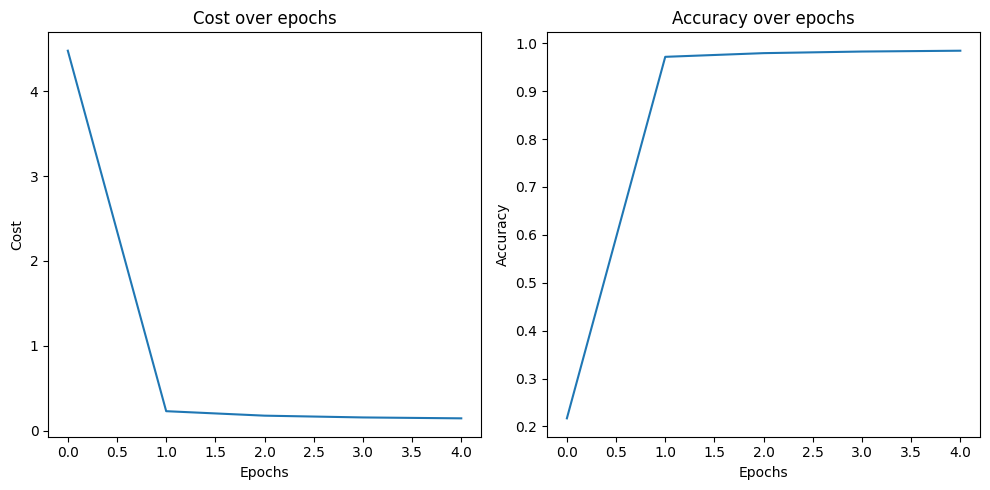

Streaming output truncated to the last 5000 lines.
       [-0.02943246],
       [ 0.00395857],
       [-0.00769509],
       [-0.06081982],
       [ 0.04018422],
       [-0.00312034],
       [-0.04005882],
       [ 0.00473581],
       [ 0.04281849],
       [-0.12716495],
       [-0.01175768],
       [-0.01050415]]), array([[-9.66081802e-03],
       [ 4.33923580e-03],
       [-2.81547300e-02],
       [ 2.06578113e-02],
       [ 6.72327805e-02],
       [-1.93884485e-02],
       [-4.29715404e-02],
       [-6.28405322e-05],
       [-4.51635598e-02],
       [-2.37847099e-03],
       [-3.15497256e-02],
       [-2.66270167e-02],
       [-6.23126168e-02],
       [ 5.29654399e-02],
       [-3.57007349e-02],
       [ 1.79037419e-03],
       [ 1.05713219e-03],
       [ 2.96688276e-02],
       [-3.50653406e-03],
       [-6.02377959e-02],
       [ 4.48772888e-02],
       [-7.65826021e-03],
       [ 4.22354721e-02],
       [-1.37712852e-02],
       [ 3.16537328e-02],
       [ 1.21684740e-02],
       

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Weight W3: [array([[ 1.81979018e-01,  6.82835340e-02,  2.42717496e-01,
         3.29086859e-01, -2.47329768e-01, -1.66033918e-02,
        -1.65300317e-01,  3.25986293e-01,  1.46420017e-01,
         2.63637060e-01, -1.24248650e-01, -5.96710022e-01,
         2.10625385e-01, -6.93544540e-02, -9.93391531e-02,
        -2.54669214e-01,  4.21853874e-01, -1.54915782e-02,
         3.00501901e-01,  7.14832861e-02],
       [-8.62425748e-02,  2.92845173e-01,  4.98525001e-02,
         6.04985162e-01,  4.87697213e-01,  1.41416056e-01,
         3.16897418e-01,  7.41077937e-02,  8.85780992e-02,
        -8.09148542e-01, -3.35885090e-01, -4.05971946e-01,
         1.05796219e-02,  2.50488633e-01,  4.35935704e-01,
        -6.02899039e-01,  2.80363204e-01, -3.71883861e-02,
         7.70806117e-02, -3.85726705e-01],
       [ 3.90208719e-01, -3.40189789e-01,  4.22600564e-04,
         6.87620664e-02, -4.29627999e-02, -1.32049680e-01,
        -3.66077244e-01,  2.09729748e-01, -3.95005763e-01,
         2.559740

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
# He
layer_dims = [x_train.shape[1], 30, 20, 10]
costs, weights, gradients, biases, gradient_biases = model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu")
# Print weights
for l in range(1, len(layer_dims)):
    print(f'Weight W{l}: {weights[f"W{l}"]}')
    print(f'Gradient dW{l}: {gradients[f"dW{l}"]}')
    print(f'Bias b{l}: {biases[f"b{l}"]}')
    print(f'Gradient db{l}: {gradient_biases[f"db{l}"]}')

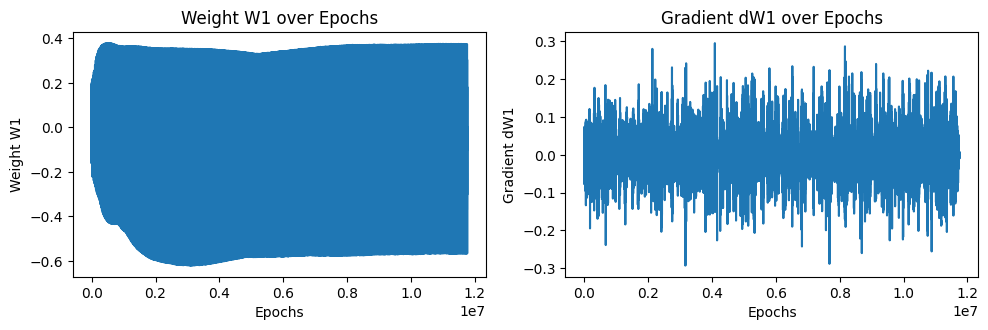

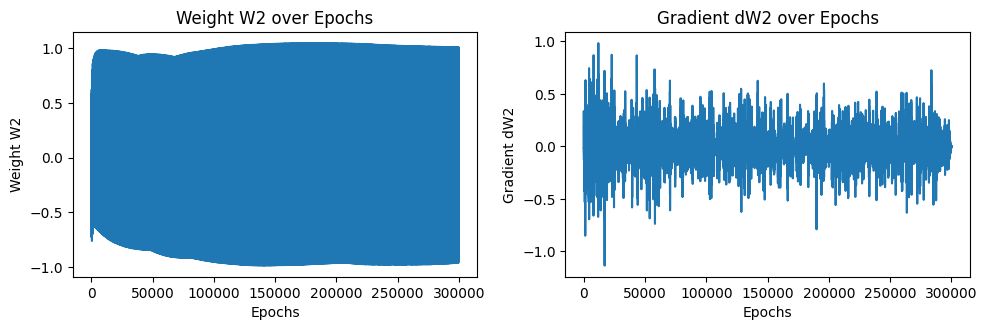

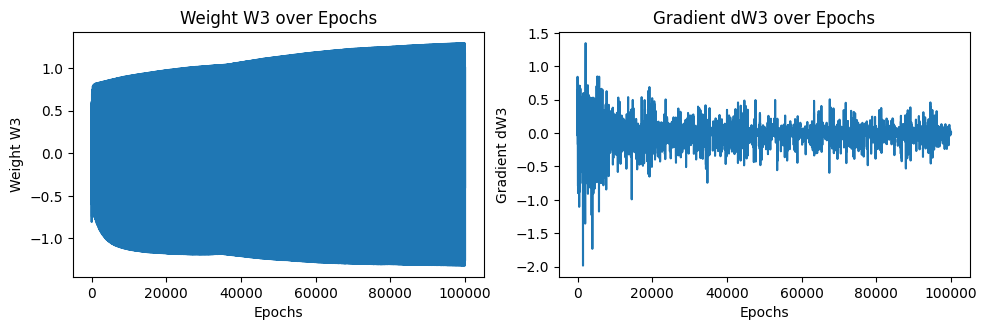

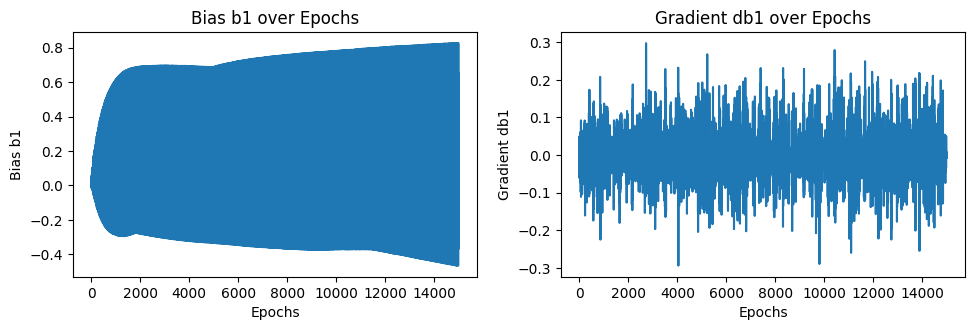

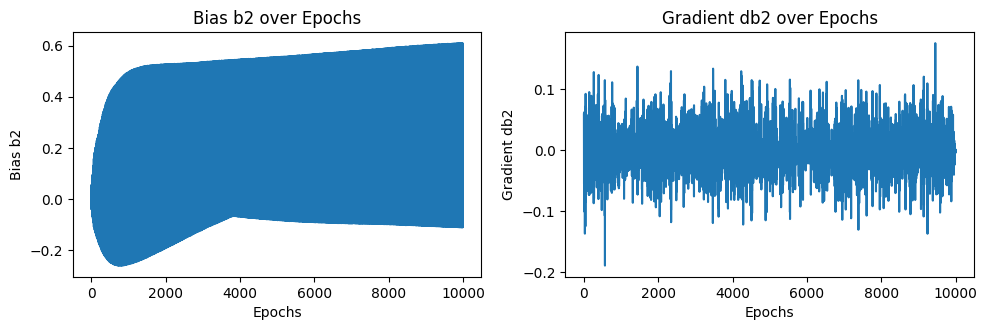

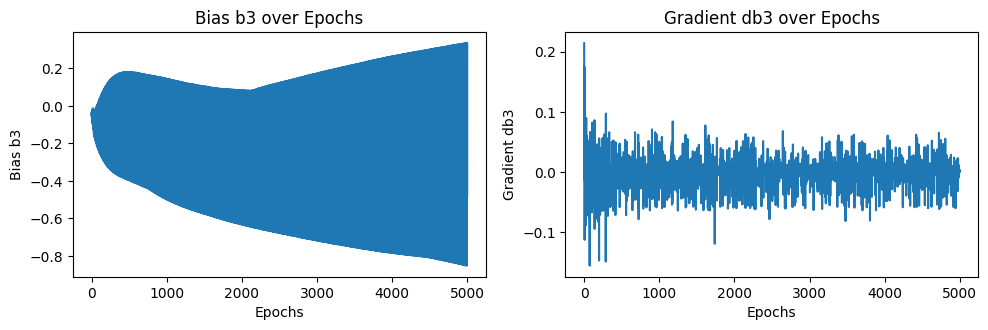

In [46]:
# Call the methods to plot weights and gradients
plot_weights_gradients(layer_dims, weights, gradients)

# Call the methods to plot biases and gradient biases
plot_biases_gradient_biases(layer_dims, biases, gradient_biases)


In [ ]:
# He
layer_dims = [x_train.shape[1], 30, 20, 10]
costs, weights, gradients, biases, gradient_biases = model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu",preprocess="stand")
# Print weights
for l in range(1, len(layer_dims)):
    print(f'Weight W{l}: {weights[f"W{l}"]}')
    print(f'Gradient dW{l}: {gradients[f"dW{l}"]}')
    print(f'Bias b{l}: {biases[f"b{l}"]}')
    print(f'Gradient db{l}: {gradient_biases[f"db{l}"]}')

In [ ]:
# Call the methods to plot weights and gradients
plot_weights_gradients(layer_dims, weights, gradients)

# Call the methods to plot biases and gradient biases
plot_biases_gradient_biases(layer_dims, biases, gradient_biases)

Cost after epoch 0: 3.202176989354069, accuracy: 0.39666666666666667
cost of valid data: 2.037138087883639
Accuracy of valid data: 0.6622222222222223
Cost after epoch 100: 0.12178231283124788, accuracy: 0.9868809523809524
cost of valid data: 0.20886716395980096
Accuracy of valid data: 0.9703333333333334
Cost after epoch 200: 0.08010641418634812, accuracy: 0.9935714285714285
cost of valid data: 0.19719464486832078
Accuracy of valid data: 0.9715
Cost after epoch 300: 0.06845000426404259, accuracy: 0.9951666666666666
cost of valid data: 0.19485744703276767
Accuracy of valid data: 0.9716111111111111
Cost after epoch 400: 0.0629056527666978, accuracy: 0.9958095238095238
cost of valid data: 0.19338823564028132
Accuracy of valid data: 0.9716111111111111
Accuracy of test data: 0.9762


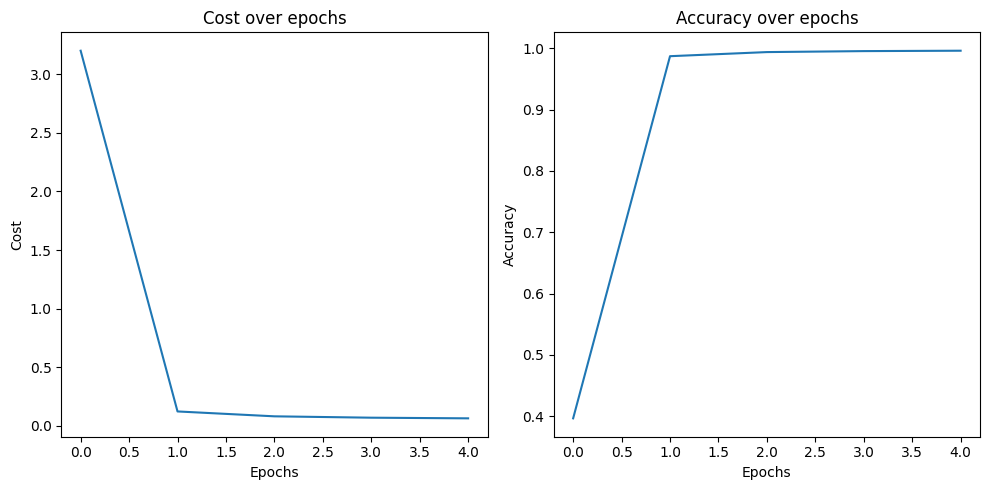

Streaming output truncated to the last 5000 lines.
         1.73147291e-02,  9.96921938e-03,  1.75581613e-02],
       ...,
       [ 2.65354655e-02, -1.02067527e-02,  3.20799363e-02, ...,
         2.53100794e-02,  3.10442123e-02,  5.12117922e-02],
       [-4.49662436e-02, -5.10108822e-04, -3.21984385e-02, ...,
        -4.27527010e-02, -3.89136041e-02, -4.68525514e-02],
       [-6.76036703e-03, -4.56744976e-03, -4.14697834e-03, ...,
        -5.61606085e-03, -2.15239313e-03, -1.47372180e-04]]), array([[-0.00184681,  0.0013562 , -0.00109739, ..., -0.00047969,
         0.00072318,  0.00050054],
       [-0.00812778,  0.00107113, -0.00816285, ..., -0.00347614,
        -0.00266912,  0.00067878],
       [-0.00202819, -0.00048955, -0.00081726, ..., -0.00072285,
         0.0005534 , -0.00062835],
       ...,
       [ 0.00540789,  0.00503017, -0.00072954, ..., -0.00090192,
        -0.00183453,  0.0056689 ],
       [ 0.00143003, -0.00177411,  0.00285114, ...,  0.00038356,
         0.00131255, -0.00

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Weight W4: [array([[ 2.52997925e-01,  4.95645689e-02, -3.98424883e-01,
        -1.95431883e-02,  5.62843602e-02, -2.38875568e-01,
        -2.63405187e-03, -1.70433232e-02, -9.34772155e-02,
         4.86131288e-01, -1.12388643e-01,  1.05983213e-01,
         3.29096329e-01, -1.55580553e-01, -3.61116032e-01,
        -3.99117459e-03,  4.51299920e-02, -1.38827983e-01,
         1.70748978e-01, -6.12459684e-01],
       [-2.02769886e-01,  2.09989120e-01, -7.18530090e-02,
        -3.24341772e-01,  6.20612286e-02,  6.22834501e-02,
        -1.98535623e-01, -7.01163382e-01, -2.81649842e-01,
        -6.30642366e-02, -2.24211992e-02,  2.70351262e-01,
         2.49135568e-02, -2.42226388e-01, -5.33685126e-01,
        -1.68858954e-01, -1.92360709e-01, -1.56705157e-01,
         1.23371703e-01,  7.79089986e-01],
       [-3.82639438e-01, -2.76012871e-01,  3.41473036e-01,
        -3.31825543e-01,  1.24987020e-01,  3.56657951e-01,
        -3.49734061e-01, -6.81760317e-01, -4.03280819e-02,
         7.772581

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [47]:
# He
layer_dims = [x_train.shape[1], 50, 30, 20, 10]
costs, weights, gradients, biases, gradient_biases = model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu")

# Print weights
for l in range(1, len(layer_dims)):
    print(f'Weight W{l}: {weights[f"W{l}"]}')
    print(f'Gradient dW{l}: {gradients[f"dW{l}"]}')
    print(f'Bias b{l}: {biases[f"b{l}"]}')
    print(f'Gradient db{l}: {gradient_biases[f"db{l}"]}')

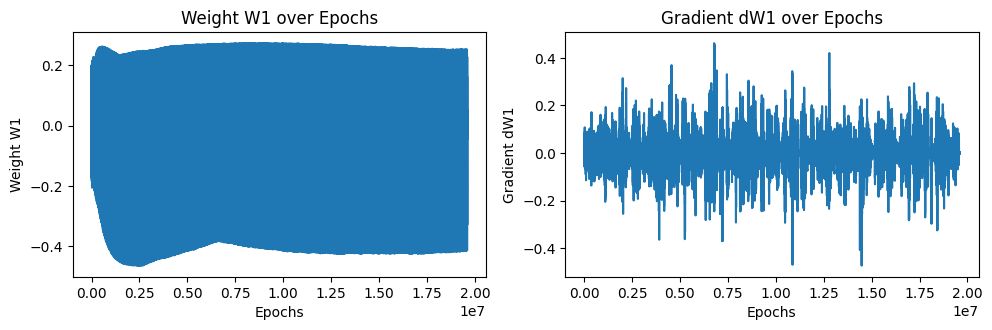

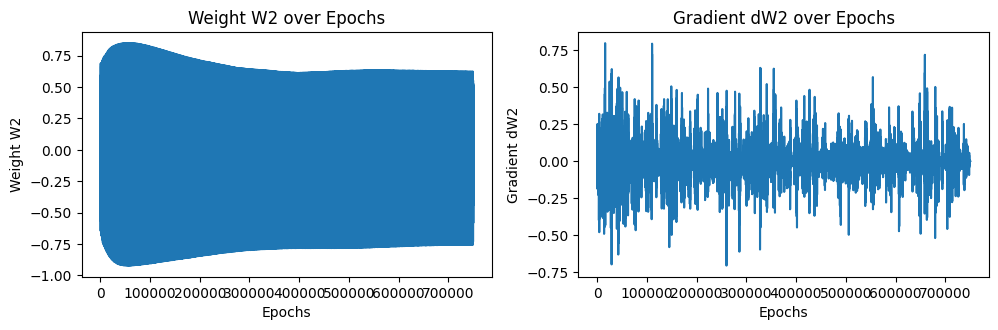

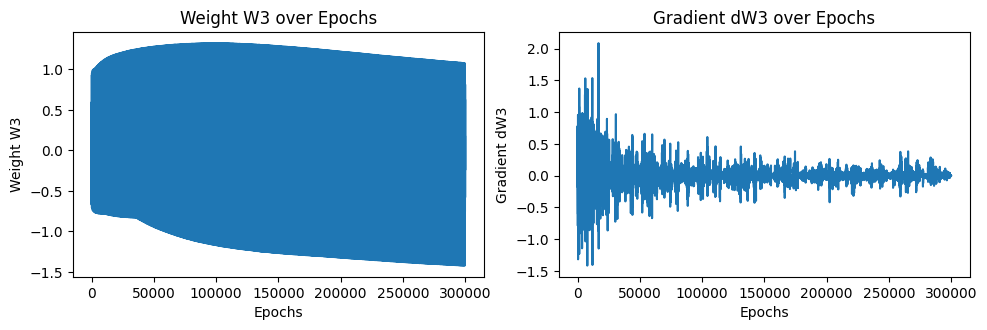

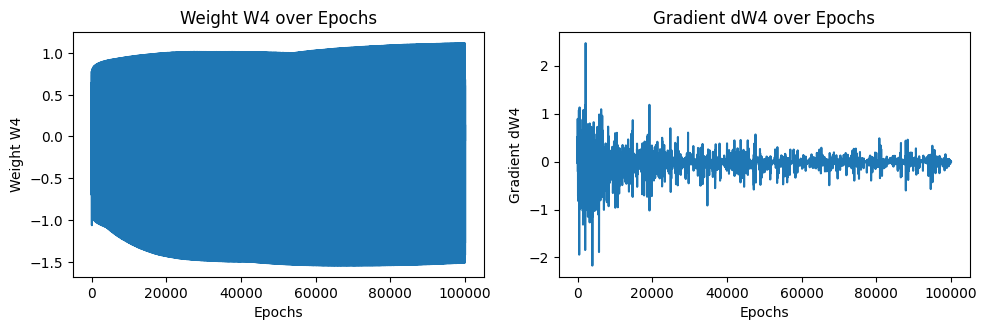

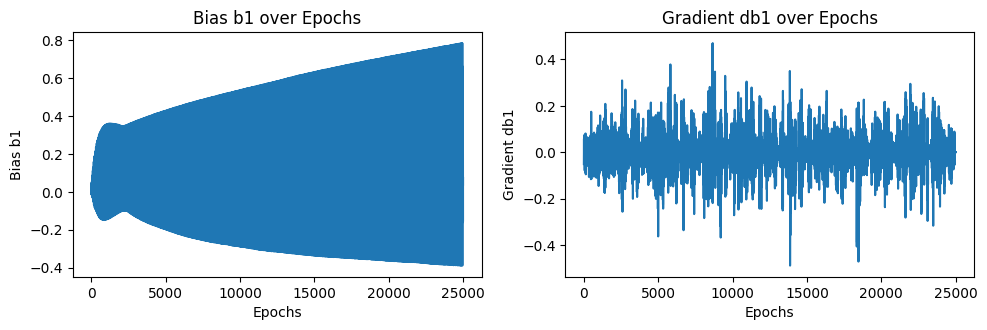

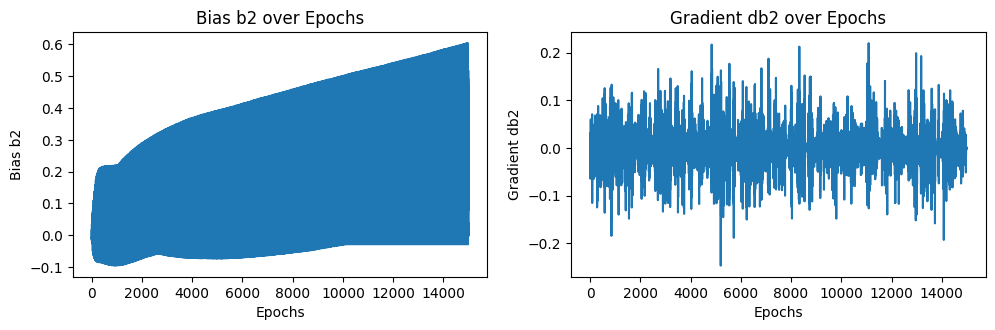

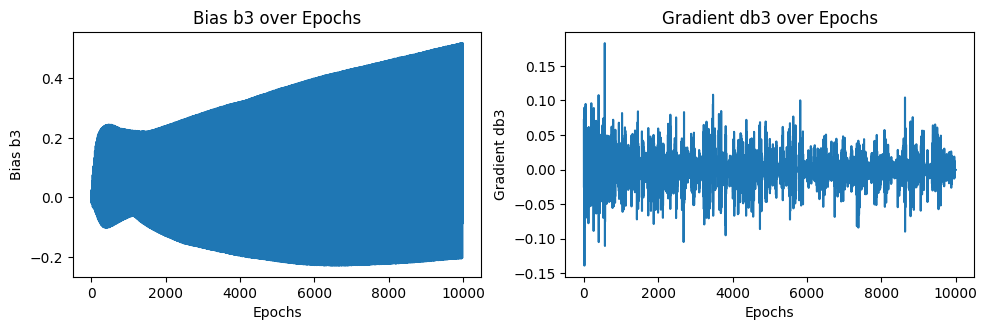

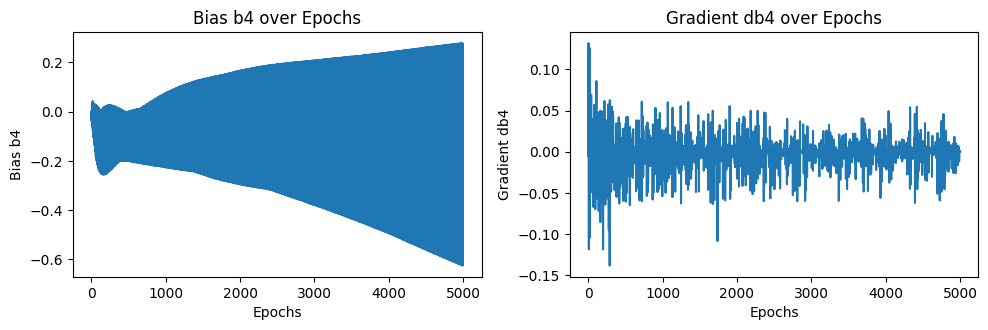

In [48]:
# Call the methods to plot weights and gradients
plot_weights_gradients(layer_dims, weights, gradients)

# Call the methods to plot biases and gradient biases
plot_biases_gradient_biases(layer_dims, biases, gradient_biases)

In [ ]:
# He
layer_dims = [x_train.shape[1], 50, 30, 20, 10]
costs, weights, gradients, biases, gradient_biases = model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu",preprocess="stand")

# Print weights
for l in range(1, len(layer_dims)):
    print(f'Weight W{l}: {weights[f"W{l}"]}')
    print(f'Gradient dW{l}: {gradients[f"dW{l}"]}')
    print(f'Bias b{l}: {biases[f"b{l}"]}')
    print(f'Gradient db{l}: {gradient_biases[f"db{l}"]}')

In [ ]:
# Call the methods to plot weights and gradients
plot_weights_gradients(layer_dims, weights, gradients)

# Call the methods to plot biases and gradient biases
plot_biases_gradient_biases(layer_dims, biases, gradient_biases)

In [ ]:
# He
layer_dims = [x_train.shape[1], 50, 30, 20, 10]
costs, weights, gradients, biases, gradient_biases = model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu",preprocess="norm_stand")

# Print weights
for l in range(1, len(layer_dims)):
    print(f'Weight W{l}: {weights[f"W{l}"]}')
    print(f'Gradient dW{l}: {gradients[f"dW{l}"]}')
    print(f'Bias b{l}: {biases[f"b{l}"]}')
    print(f'Gradient db{l}: {gradient_biases[f"db{l}"]}')

In [ ]:
# Call the methods to plot weights and gradients
plot_weights_gradients(layer_dims, weights, gradients)

# Call the methods to plot biases and gradient biases
plot_biases_gradient_biases(layer_dims, biases, gradient_biases)

In [52]:
def model(x_train, y_train, x_test, y_test, x_valid, y_valid, layers_dims, optimizer, initialization, learning_rate=0.001, mini_batch_size=64, beta=0.9,
          beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True, lambd=0, activation="relu", preprocess="norm", early_stopping_patience=10):
    """
    3-layer neural network model which can be run in different optimizer modes.

    Arguments:
    X -- input data, of shape (n_features, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost and accuracy every 1000 epochs
    lambd -- regularization hyperparameter
    activation -- activation function ("relu", "sigmoid", etc.)
    early_stopping_patience -- number of epochs to wait before stopping if validation loss doesn't improve

    Returns:
    parameters -- python dictionary containing your updated parameters
    predictions -- predictions on test data
    """
    if preprocess == "norm":
        x_train, x_valid, x_test = normalize(x_train, x_valid, x_test)
    elif preprocess == "stand":
        x_train, x_valid, x_test = standardize(x_train, x_valid, x_test)
    elif preprocess == "norm_stand":
        x_train, x_valid, x_test = normalize(x_train, x_valid, x_test)
        x_train, x_valid, x_test = standardize(x_train, x_valid, x_test)

    x_train, x_valid, x_test = x_train.T, x_valid.T, x_test.T

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    accuracies = []                  # to keep track of the accuracy
    predictions = []                 # to keep track of the predictions
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = x_train.shape[1]                   # number of training examples
    # print("number:",m)
    weights = {f'W{l}': [] for l in range(1, len(layers_dims))}
    gradients = {f'dW{l}': [] for l in range(1, len(layers_dims))}
    biases = {f'b{l}': [] for l in range(1, len(layers_dims))}
    gradient_biases = {f'db{l}': [] for l in range(1, len(layers_dims))}

    if initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    elif initialization == "xavier":
        parameters = initialize_parameters_xavier(layers_dims)

    v, s = initialize_adam(parameters)

    # Early stopping variables
    best_valid_cost = float('inf')
    epochs_without_improvement = 0
    best_parameters = None

    # Optimization loop
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(x_train, y_train, mini_batch_size, seed)
        cost_total = 0
        accuracy_total = 0

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            caches, a3 = forward_propagation(minibatch_X, minibatch_Y, parameters, activation)

            # Compute cost
            if lambd == 0:
                cost_total += compute_cost(a3, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(a3, minibatch_Y, parameters, lambd)

            accuracy_total += predict(minibatch_X, minibatch_Y, parameters, activation)

            # Backward propagation
            if lambd == 0:
                grads = backward_propagation(minibatch_X, minibatch_Y, caches, a3, activation)
            else:
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, caches, a3, lambd, activation)

            t = t + 1  # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        # Average cost and accuracy over all minibatches
        cost_avg = cost_total / m
        accuracy_avg = accuracy_total / m

        # Compute validation cost
        caches, a3 = forward_propagation(x_valid, y_valid, parameters, activation)
        valid_cost = compute_cost_with_regularization(a3, y_valid, parameters, lambd) / x_valid.shape[1]

        # Early stopping
        if valid_cost < best_valid_cost:
            best_valid_cost = valid_cost
            epochs_without_improvement = 0
            best_parameters = parameters.copy()
        else:
            epochs_without_improvement += 1

        # Print the cost and accuracy every 1000 epochs
        if print_cost and i % 100 == 0:
            print(f"Cost after epoch {i}: {cost_avg}, accuracy: {accuracy_avg}")
            print(f"cost of valid data: {valid_cost}")
            print(f"Accuracy of valid data: {predict(x_valid, y_valid, parameters, activation) / x_valid.shape[1]}")

        # Append the cost and accuracy to the lists
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
            accuracies.append(accuracy_avg)

        # Check for early stopping
        if epochs_without_improvement == early_stopping_patience:
            print(f"Early stopping at epoch {i}. Best validation cost: {best_valid_cost}")
            break

    # Use the parameters with the best validation cost
    parameters = best_parameters

    # Plot the cost, accuracy, and predictions
    test_prediction = predict(x_test, y_test, parameters, activation) / x_test.shape[1]
    print(f"Accuracy of test data: {test_prediction}")
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(costs)
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title("Cost over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy over epochs")

    plt.tight_layout()
    plt.show()


In [ ]:
# He
layer_dims = [x_train.shape[1], 30, 20, 10]
model(x_train, y_train, x_test, y_test, x_valid, y_valid, layer_dims, optimizer="adam", initialization="he", learning_rate=0.0001, mini_batch_size=64, beta=0.9, beta1=0.9, beta2=0.99, num_epochs=500, print_cost=True, lambd=0.1, activation="relu")

Cost after epoch 0: 4.478081366241306, accuracy: 0.21683333333333332
cost of valid data: 2.642378045975512
Accuracy of valid data: 0.42694444444444446
Cost after epoch 100: 0.22924059766068317, accuracy: 0.9715952380952381
cost of valid data: 0.28522771448196815
Accuracy of valid data: 0.9609444444444445
Cost after epoch 200: 0.17651748714187915, accuracy: 0.9792857142857143
cost of valid data: 0.2499651722982882
Accuracy of valid data: 0.9654444444444444
Cost after epoch 300: 0.15557636043051074, accuracy: 0.9826428571428572
cost of valid data: 0.2367963271538389
Accuracy of valid data: 0.9672777777777778
